In [1]:
%matplotlib inline

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from common.databases.mdb import Reader
import struct
import random
import tensorflow as tf
from IPython.display import Markdown, display
from sklearn import metrics
import os

# Utils 

In [2]:
def make_sure_path_exists(path):
    try:
        os.makedirs(os.path.dirname(path))
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
        
def plot_images(images, ncols=None):
    ncols = ncols if ncols else len(images)
    images =  np.array(images) 
    nindex, height, width = images.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (images.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(result,  cmap='gray')
    plt.axis('off')
    plt.show()
    plt.clf()
    
def error_rate(predictions, labels):
    return (100.0 * np.sum(predictions != labels)/ len(predictions))

def get_incorrect_predictions(predictions, labels):
    return [i for i, (pred, lab) in enumerate(zip(predictions, labels)) if pred != lab]

def get_predictions(prob):
    return np.argmax(prob, 1)

def printmd(string):
    display(Markdown(string))


# Load data 
It is not a lot, it fits in memory

Split trainset to trainset, validset. Otherwise it would be cheating


In [3]:
validset_size = 10000

# Got from https://gist.github.com/akesling/5358964
def read_mnist(dataset, path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError( "dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

trainset = list(read_mnist("training", "data")) 
validset = trainset[:validset_size]
trainset = trainset[validset_size:]
print("Loaded {} trainset images".format(len(trainset)))
print("Loaded {} validset images".format(len(validset)))

testset = list(read_mnist("testing", "data"))
print("Loaded {} testset images".format(len(testset)))

Loaded 50000 trainset images
Loaded 10000 validset images
Loaded 10000 testset images


Trainset (3, 8, 7, 9, 9, 0, 1, 1, 5, 2, 0, 3, 8, 4, 7)


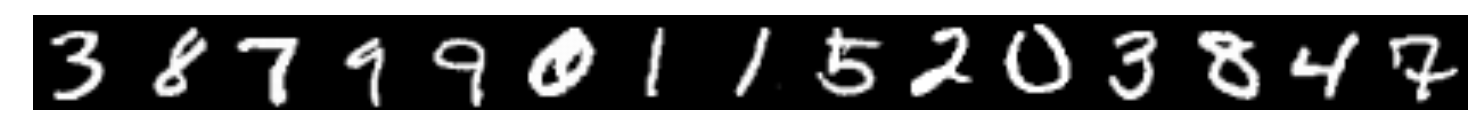

Validset (5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1)


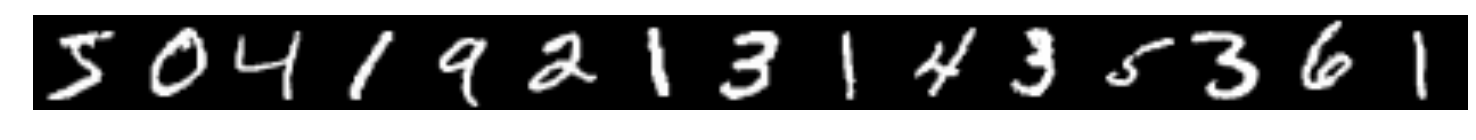

Testset (7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1)


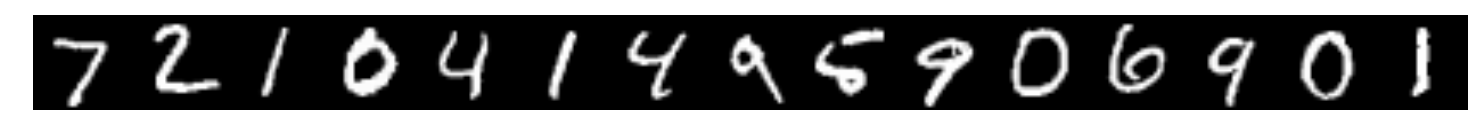

In [4]:
labels, images = zip(*trainset[:15])
print("Trainset", labels)
plot_images(images)

labels, images = zip(*validset[:15])
print("Validset", labels)
plot_images(images)

labels, images = zip(*testset[:15])
print("Testset", labels)
plot_images(images)

# Some stats

In [5]:
label_distribution = Counter([example[0] for example in trainset])
print("Trainset distribution", label_distribution)

label_distribution = Counter([example[0] for example in validset])
print("Validset distribution", label_distribution)

label_distribution = Counter([example[0] for example in testset])
print("Testset distribution", label_distribution)

image_width, image_height = np.array(trainset[0][1]).shape
print("Shape:", image_width, image_height)

Trainset distribution Counter({1: 5615, 7: 5195, 3: 5099, 9: 4971, 2: 4967, 0: 4922, 8: 4907, 6: 4904, 4: 4862, 5: 4558})
Validset distribution Counter({1: 1127, 7: 1070, 3: 1032, 6: 1014, 0: 1001, 2: 991, 4: 980, 9: 978, 8: 944, 5: 863})
Testset distribution Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})
Shape: 28 28


Almost equally distributed => OK

# Preprocess

In [6]:
num_channels = 1
num_labels = 10
offset = 128

def encode_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def preprocess(dataset):
    random.shuffle(dataset)  # Just in case it was somehow sorted
    labels, images = zip(*dataset)
    labels, images = np.array(labels, dtype="int"), np.array(images, dtype="float32")
    images -= offset  # To be zero centred
    
    images = images.reshape((-1, image_width, image_height, num_channels))  # Add channel dimension

    return labels, images
    
train_labels, train_images = preprocess(trainset)
valid_labels, valid_images = preprocess(validset)
test_labels, test_images = preprocess(testset)

train_labels_oh = encode_one_hot(train_labels)

## Check dimensions, types etc.
Just to make sure preprocessing is correct

Checking shapes, dtypes, values

train_labels_oh float32 (50000, 10)
train_images float32 (50000, 28, 28, 1) -128.0 127.0


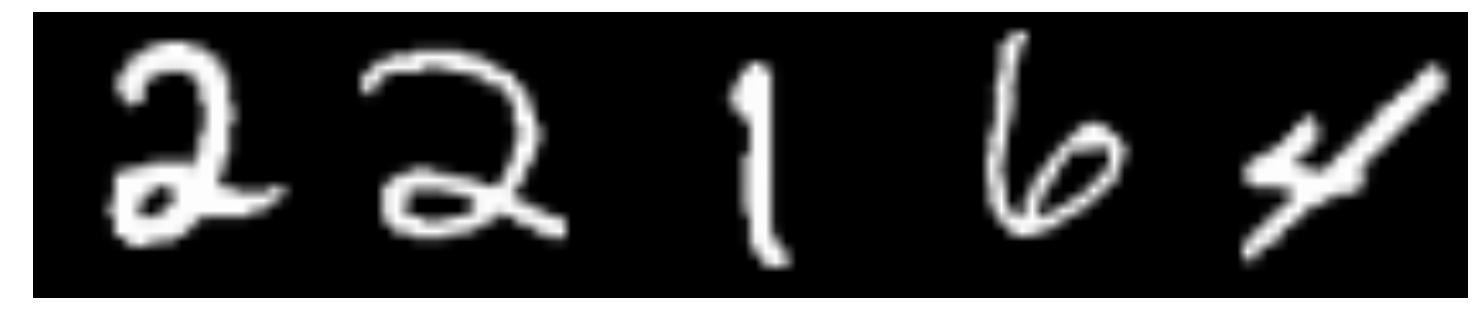

Train labels
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [7]:
print("Checking shapes, dtypes, values\n")
print("train_labels_oh", train_labels_oh.dtype, train_labels_oh.shape)
print("train_images", train_images.dtype, train_images.shape, min(train_images[0, :, :].ravel()), max(train_images[0, :, :].ravel()))
plot_images(train_images[0:5,:,:,0])
print("Train labels")
print(train_labels_oh[0:5, :])

# Training

## Define computational graph
Using  architecture similar to <a href="https://arxiv.org/abs/1512.03385">Resnet</a>. Used much shallower then in the paper. After resnet blocks used dropout and 2 fully connected layers with softmax. As a loss function used cross entropy, optimizer Adam.

In [8]:
batch_size = 128
filter_size = 3
nr_filters = 16
num_hidden = 128
nr_resnet_blocks = 3
learning_rate = 0.001

tf.reset_default_graph() 

# Input data.
tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, num_channels))
tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
tf_valid_dataset = tf.constant(valid_images)
tf_test_dataset = tf.constant(test_images)
training = tf.placeholder(tf.bool, shape=None)

# Variables.
layer1in_weights = tf.Variable(tf.truncated_normal([5, 5, num_channels, nr_filters], stddev=0.1))
layer1in_biases = tf.Variable(tf.zeros([nr_filters]))

layer1fc_weights = tf.Variable(tf.truncated_normal([image_width // 4 * image_height // 4 * nr_filters, num_hidden], stddev=0.1))
layer1fc_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
layer2fc_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
layer2fc_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

# Model.
def model(data, reuse=False):
    data = tf.nn.conv2d(data, layer1in_weights, [1, 2, 2, 1], padding='SAME') + layer1in_biases
    data = tf.nn.relu(data)
    for i_resnet_block in range(nr_resnet_blocks):
        data = resnet_block(data, i_resnet_block, reuse)

    data = tf.nn.max_pool(data, [1, 3, 3, 1],  [1, 2, 2, 1],  padding='SAME')
    hidden = tf.layers.dropout(data, training=training)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])  # Unroll
    hidden = tf.nn.relu(tf.matmul(reshape, layer1fc_weights) + layer1fc_biases)
    return tf.matmul(hidden, layer2fc_weights) + layer2fc_biases

def resnet_block(data, i_resnet_block, reuse):
    with tf.variable_scope("scope", reuse=reuse):
        layer1_weights = tf.get_variable("layer1_weights_"+str(i_resnet_block), initializer=tf.truncated_normal([filter_size, filter_size, nr_filters, nr_filters], stddev=0.1))
        layer1_biases = tf.get_variable("layer1_biases_"+str(i_resnet_block), initializer=tf.zeros([nr_filters]))

        layer2_weights = tf.get_variable("layer2_weights_"+str(i_resnet_block), initializer=tf.truncated_normal([filter_size, filter_size, nr_filters, nr_filters], stddev=0.1))
        layer2_biases = tf.get_variable("layer2_biases_"+str(i_resnet_block), initializer=tf.constant(1.0, shape=[nr_filters]))
    
    data = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
    data = tf.nn.relu(data)
    
    data = tf.nn.conv2d(data, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
    
    data = tf.ones_like(data) + data
    data = tf.nn.relu(data)
    return data

# Training computation.
logits = model(tf_train_dataset)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

# Optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Predictions for the training, validation, and test data.
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset, reuse=True))
test_prediction = tf.nn.softmax(model(tf_test_dataset, reuse=True))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

## Run computational graph
Trained using GPU, on CPU training might take a while.

In [9]:
num_steps = 10001
model_path = "models/model.ckpt"

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.global_variables_initializer().run(session=sess)

min_valid_err = 100
for step in range(num_steps):
    offset = (step * batch_size) % (train_labels_oh.shape[0] - batch_size)
    batch_data = train_images[offset:(offset + batch_size), :, :, :]
    batch_labels_oh = train_labels_oh[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels_oh, training:True}
    _, l, p_train = sess.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    # Printing stats, storing model if good
    if (step % 100 == 0):
        p_valid = valid_prediction.eval(session=sess, feed_dict={training: False})
        
        train_batch_err =  error_rate(get_predictions(p_train), get_predictions(batch_labels_oh))
        valid_err =  error_rate(get_predictions(p_valid), valid_labels)

        star = ""
        if  valid_err < min_valid_err:
            star = "*"
            min_valid_err = valid_err
            saver.save(sess, model_path)

        print("Step: {:04d}, train_batch_loss: {:.3f}, train_batch_err: {:.2f}%, valid_err: {:.2f}%{}"
              .format(step, l, train_batch_err, valid_err, star))
        
printmd("** Valid err rate {}% **".format(min_valid_err))     


Step: 0000, train_batch_loss: 35.611, train_batch_err: 89.84%, valid_err: 89.26%*
Step: 0100, train_batch_loss: 1.260, train_batch_err: 47.66%, valid_err: 26.90%*
Step: 0200, train_batch_loss: 0.505, train_batch_err: 17.19%, valid_err: 9.25%*
Step: 0300, train_batch_loss: 0.210, train_batch_err: 5.47%, valid_err: 6.42%*
Step: 0400, train_batch_loss: 0.321, train_batch_err: 10.94%, valid_err: 4.64%*
Step: 0500, train_batch_loss: 0.196, train_batch_err: 7.03%, valid_err: 5.58%
Step: 0600, train_batch_loss: 0.439, train_batch_err: 12.50%, valid_err: 4.03%*
Step: 0700, train_batch_loss: 0.139, train_batch_err: 5.47%, valid_err: 3.14%*
Step: 0800, train_batch_loss: 0.057, train_batch_err: 1.56%, valid_err: 3.21%
Step: 0900, train_batch_loss: 0.273, train_batch_err: 6.25%, valid_err: 2.89%*
Step: 1000, train_batch_loss: 0.120, train_batch_err: 5.47%, valid_err: 2.97%
Step: 1100, train_batch_loss: 0.060, train_batch_err: 2.34%, valid_err: 2.97%
Step: 1200, train_batch_loss: 0.025, train_batch

** Valid err rate 0.94% **

# Evaluation

In [10]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    p_test = test_prediction.eval(session=sess, feed_dict={training: False})

test_predictions = get_predictions(p_test)
test_err =  error_rate(test_predictions, test_labels)
printmd("** Test err rate {}% **".format(test_err)) 

INFO:tensorflow:Restoring parameters from models/model.ckpt


** Test err rate 0.66% **

## Draw incorrect predictions
Normally usefull for tweaking training data

Predictions: [3 9 0 0 2 5 4 2 3 7 6 4 3 9 5]
True labels: [1 4 2 6 7 9 9 7 8 2 5 9 5 4 3]


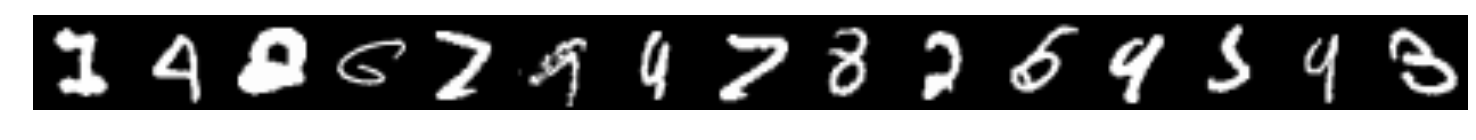

In [11]:
incorrect_predictions = get_incorrect_predictions(test_predictions, test_labels)

nr_incorrect = 15
print("Predictions:", test_predictions[incorrect_predictions[:nr_incorrect]])
print("True labels:", test_labels[incorrect_predictions[:nr_incorrect]])
plot_images([test_images[i, :, :, 0] + offset for i in incorrect_predictions[:nr_incorrect]])

## Print confusion matrix

In [12]:
print("True", " "*20 + "Predicted")
print(metrics.confusion_matrix(test_labels, test_predictions))

True                     Predicted
[[ 978    0    0    0    0    0    0    1    1    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   1    1 1026    0    0    0    0    1    3    0]
 [   0    0    0 1000    0    3    0    2    2    3]
 [   1    0    0    0  974    0    1    0    0    6]
 [   1    0    0    4    0  884    2    0    1    0]
 [   3    2    0    0    0    1  951    0    1    0]
 [   0    1    3    0    0    0    0 1021    0    3]
 [   0    0    2    2    0    1    0    0  967    2]
 [   0    0    0    0    4    2    0    2    1 1000]]
